<a href="https://colab.research.google.com/github/Saibot19/7506R-1C2023-GRUPO21/blob/main/7506R_TP1_GRUPO21_CHP2_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arboles


## Importaciones



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from google.colab import drive


#modelos y métricas
import sklearn as sk
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_text


drive.mount('/content/drive', force_remount=True)
df_trabajo = pd.read_csv("/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Datasets/hotels_train_filtered.csv")
df_test = pd.read_csv("/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Datasets/hotels_test.csv")

df_trabajo

Mounted at /content/drive


hotel  lead_time  arrival_date_year arrival_date_month  \
0        City Hotel         49               2016          September   
1      Resort Hotel          4               2015            October   
2        City Hotel         25               2016            October   
3        City Hotel         26               2016           December   
4        City Hotel        104               2017              March   
...             ...        ...                ...                ...   
60627  Resort Hotel         24               2017            January   
60628    City Hotel          0               2016          September   
60629    City Hotel         10               2017                May   
60630  Resort Hotel        143               2015            October   
60631    City Hotel         57               2016              April   

       arrival_date_week_number  arrival_date_day_of_month  \
0                            37                          5   
1                            44                         31   
2                            42                         13   
3                            51                         12   
4                            12                         19   
...                         ...                        ...   
60627                         4                         27   
60628                        36                          2   
60629                        19                          8   
60630                        41                         10   
60631                        17                         17   

       stays_in_weekend_nights  stays_in_week_nights  adults  children  ...  \
0                            1                     2       1       0.0  ...   
1                            0                     1       2       0.0  ...   
2                            0                     1       2       2.0  ...   
3                            2                     5       2       0.0  ...   
4                            2                     5       2       0.0  ...   
...                        ...                   ...     ...       ...  ...   
60627                        0                     2       2       0.0  ...   
60628                        0                     1       1       0.0  ...   
60629                        1                     2       1       0.0  ...   
60630                        2                     5       2       0.0  ...   
60631                        2                     5       2       0.0  ...   

       days_in_waiting_list    customer_type     adr  \
0                         0        Transient  115.50   
1                         0        Transient   42.00   
2                         0        Transient  229.00   
3                         0        Transient   75.00   
4                         0  Transient-Party   75.00   
...                     ...              ...     ...   
60627                     0        Transient   48.00   
60628                     0        Transient  149.00   
60629                     0        Transient   95.00   
60630                     0        Transient   36.05   
60631                     0        Transient  143.29   

      required_car_parking_spaces total_of_special_requests  \
0                               0                         1   
1                               1                         0   
2                               0                         2   
3                               0                         0   
4                               0                         1   
...                           ...                       ...   
60627                           0                         1   
60628                           0                         0   
60629                           0                         0   
60630                           0                         0   
60631                           0                         0   

                         

## Seteo para la evaluacion


- Construir árboles de decisión y optimizar sus hiperparámetros mediante k-fold
Cross Validation para obtener la mejor performance. ¿Cuántos folds utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

- Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.
- Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y decisiones evaluadas (explicar las primeras reglas obtenidas).
- Evaluar la performance del modelo en entrenamiento y validación, explicar todas
las métricas y mostrar la matriz de confusión.
- Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.

In [ ]:
#df_trabajo.drop(['children','babies','meal'], axis='columns',inplace=True)


In [ ]:
df_trabajo['is_canceled'].value_counts(normalize=True)*100

1    50.216058
0    49.783942
Name: is_canceled, dtype: float64

### Label Enonder

In [ ]:
df_trabajo_x_LE = df_trabajo.drop(['is_canceled','id'], axis='columns')
df_trabajo_y = df_trabajo['is_canceled'].copy()

In [ ]:
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

le = LabelEncoder()
# Convertimos nulos a string 'nan', es decir un valor posible mas
for column in df_trabajo_x_LE.columns:
    if df_trabajo_x_LE[column].dtype == 'object':
        df_trabajo_x_LE[column] = le.fit_transform(df_trabajo_x_LE[column])

In [ ]:
#Separo un set de Evaluacion

x_train_LE, x_test_LE, y_train_LE, y_test_LE = train_test_split(df_trabajo_x_LE, 
                                                    df_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_trabajo_y) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train_LE)))
print('# Datos Prueba: {}'.format(len(x_test_LE)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_LE,y_test_LE]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48505
# Datos Prueba: 12127
% Positivos Entrenamiento: 50.215
% Positivos Prueba: 50.219


### One hot encoding

In [ ]:
df_trabajo_x_OHE = df_trabajo.drop(['is_canceled','id'], axis='columns')

In [ ]:

df_trabajo_x_OHE = pd.get_dummies(df_trabajo_x_OHE, columns=['hotel','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type'], drop_first=True)
#df_trabajo_x_OHE = pd.get_dummies(df_trabajo_x_OHE, columns=['country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type'], drop_first=True)

# Hay un par de variables que no consideramos que sea mejor con OHE como los mese que ya tienen un orden o meal que solo creemos que va agregar ruido
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

le = LabelEncoder()
# Convertimos nulos a string 'nan', es decir un valor posible mas
for column in df_trabajo_x_OHE.columns:
    if df_trabajo_x_OHE[column].dtype == 'object':
        df_trabajo_x_OHE[column] = le.fit_transform(df_trabajo_x_OHE[column])

In [ ]:
len(df_trabajo_x_OHE.columns.to_list())

63

In [ ]:
x_train_OHE, x_test_OHE, y_train_OHE, y_test_OHE = train_test_split(df_trabajo_x_OHE, 
                                                    df_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_trabajo_y) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train_OHE)))
print('# Datos Prueba: {}'.format(len(x_test_OHE)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_OHE,y_test_OHE]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48505
# Datos Prueba: 12127
% Positivos Entrenamiento: 50.215
% Positivos Prueba: 50.219


### One Hot Enconding vs Label Enconder

Aca vamos a probar cual de los dos nos da un mejor score dejando con overfitting

#### Arbol con Label Encoder

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005), ## Dejamos default 50
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
cv1 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

#Busco los hiperparamtros que optimizan F1 Score
cv1.fit(x_train_LE,y_train_LE);

#Mejores hiperparametros del arbol
print(cv1.best_params_)
#Mejor métrica
print(cv1.best_score_)

{'ccp_alpha': 0.00010204081632653062, 'criterion': 'gini'}
0.8601756371506901


#### Arbol con One Hot Encoding (Mejor arbol)

In [ ]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005),## Dejamos default 50
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
cv2 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

#Busco los hiperparamtros que optimizan F1 Score
cv2.fit(x_train_OHE,y_train_OHE);

#Mejores hiperparametros del arbol
print(cv2.best_params_)
#Mejor métrica
print(cv2.best_score_)

{'ccp_alpha': 0.00020408163265306123, 'criterion': 'entropy'}
0.8612946328743935


In [ ]:
y_pred = cv2.predict(x_test_OHE)
accuracy5 = accuracy_score(y_test_OHE, y_pred)
print(accuracy5)

0.8612187680382617


In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import export_text
arbol=DecisionTreeClassifier().set_params(**cv2.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(df_trabajo_x))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- habitacion_correcta <= 0.50
|   |   |--- country_PRT <= 0.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- distribution_channel_TA/TO <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- distribution_channel_TA/TO >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- booking_changes <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- booking_changes >  0.50
|   |   |   |   |   |--- assigned_room_type_Otros <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- assigned_room_type_Otros >  0.50
|   |   |   |   |   |   |--- lead_time <= 22.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- lead_time >  22.50
|   |   |   |   |   |   |   |--- customer_type_Transient <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- customer_type_Transient >  0.50
|   |   |   |   |   |

Explicación de los primeros niveles del árbol:
  - En el primer nodo, notamos que se utiliza el tipo de deposito no refundable, ya que como vimos en el preprocesamiento de datos del TP1, existia una gran tendencia a cancelar la reserva en estos casos.
  - Segundo nivel:
    -  Ya en el segundo nivel observamos que para aquellas reservas con deposito  refundable (casos menores o iguales a 0.5), basa su decision en si la habitacion asignada es la correcta, en relacion a la habitacion reservada. Se nota una tendencia a no cancelar cuando el cuarto no es correcto.
    - En los casos en que el deposito es no refundable, analiza el pais de la reserva. Se nota una gran tendencia a que cuando la reserva no es en alemania tienden a cancelar. Teniendo en cuenta que previamente, el deposito era no renfundable.
  - Tercer Nivel:
    - Si la habitacion es correcta, analiza la necesidad de espacios de estacionamiento. Notamos que en los casos en que necesitan, tienden a no cancelar, como pudimos observar en el preprocesamiento.
    - Cuando la habitacion no es correcta, se continua el analisis, observando si el pais es portugal o no. Notamos que en los casos en que la reserva es en Portugal, la tendencia a cancelar es menor, a diferencia de lo que vimos en el checkpoint 1, esto se debe probablemente por el pre filtrado.
    - Cuando la reserva no se realiza en alemania, teniendo en cuenta que el deposito fue no refundable, Se analiza si el tipo de cliente es un "Transient party". Notando que en caso de serlo, cancelan en la gran mayoria de casos.

In [ ]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=df_trabajo_x.columns.to_list(),
                class_names=['No Cancelado','Cancelado'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      6037
           1       0.86      0.86      0.86      6090

    accuracy                           0.86     12127
   macro avg       0.86      0.86      0.86     12127
weighted avg       0.86      0.86      0.86     12127

F1-Score: 0.8617458490876213


Text(50.722222222222214, 0.5, 'True')

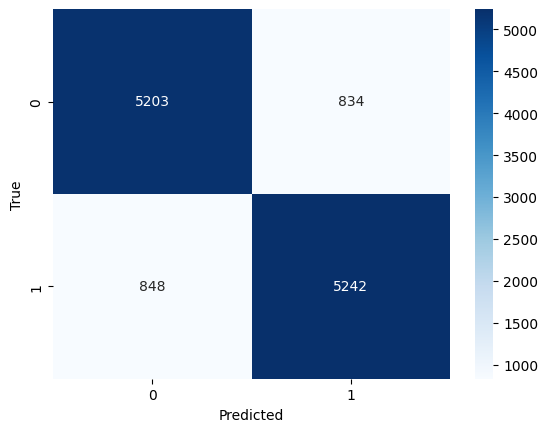

In [ ]:
#Evalúo el Arbol con los mejores hiperparámetros

#Hago predicción sobre el set de evaluacion
y_pred= arbol.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Podemos ver que OHE nos da un mejor puntaje y aunque duplica las columnas reduciendo un poco la importacia de algunas otras variables tiene mas sentido ya que no es lo mismo tener un true o false para los paises que un secuencia de valores donde PRT < GBT. 

### Seteo Final

In [ ]:
df_trabajo_x = df_trabajo_x_OHE

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, 
                                                    df_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_trabajo_y) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train_OHE)))
print('# Datos Prueba: {}'.format(len(x_test_OHE)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_OHE,y_test_OHE]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48505
# Datos Prueba: 12127
% Positivos Entrenamiento: 50.215
% Positivos Prueba: 50.219


## Arbol 1 - Random Search 

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv1 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv1.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv1.best_params_)
#Mejor métrica
print(randomcv1.best_score_)

{'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.0023684210526315787}
0.8085903714439493


In [ ]:
y_pred1 = randomcv1.predict(x_test)
accuracy1 = accuracy_score(y_test, y_pred1)
print(accuracy1)

0.7757895604848685


## Arbol 2 - Random Search

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv2 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv2.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv2.best_params_)
#Mejor métrica
print(randomcv2.best_score_)

{'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.0018421052631578947}
0.8381944264082687


In [ ]:
y_pred2 = randomcv2.predict(x_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print(accuracy2)

0.833511998020945


## Arbol 3 - Random Search

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv3 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv3.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv3.best_params_)
#Mejor métrica
print(randomcv3.best_score_)

{'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.0007142857142857143}
0.8411540980781398


In [ ]:
y_pred3 = randomcv3.predict(x_test)
accuracy3 = accuracy_score(y_test, y_pred3)
print(accuracy3)

0.8420054424012534


## Arbol 4 - Random Search

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=100

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv4 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv4.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv4.best_params_)
#Mejor métrica
print(randomcv4.best_score_)

{'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.0020707070707070706}
0.8372719006737688


In [ ]:
y_pred4 = randomcv4.predict(x_test)
accuracy4 = accuracy_score(y_test, y_pred4)
print(accuracy4)

0.8316978642698112


## Arbol 5 - Random Search (2º arbol seleccionado para la entrega, con max depth)

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.01,n), 
               'max_depth':list(range(1,14))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv5 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv5.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv5.best_params_)
#Mejor métrica
print(randomcv5.best_score_)

{'max_depth': 12, 'criterion': 'gini', 'ccp_alpha': 0.0010204081632653062}
0.8411070132686875


In [ ]:
y_pred5 = randomcv5.predict(x_test)
accuracy5 = accuracy_score(y_test, y_pred5)
print(accuracy5)

0.8334295373958934


In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import export_text
arbol=DecisionTreeClassifier().set_params(**randomcv5.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(df_trabajo_x))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- habitacion_correcta <= 0.50
|   |   |--- class: 0
|   |--- habitacion_correcta >  0.50
|   |   |--- lead_time <= 11.50
|   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- required_car_parking_spaces >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |--- class: 1
|   |   |--- lead_time >  11.50
|   |   |   |--- country_PRT <= 0.50
|   |   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |   |--- market_segment_Direct <= 0.50
|   |   |   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- market_segment_Direct >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- market_segment_Online TA >  0.5

In [ ]:
best_tree = randomcv3.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_trabajo_x.columns.to_list())):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

agent_cancela_seguido: 0.0013920326837467932
meal: 0.001424684993377837
adr: 0.0014640459248121281
distribution_channel_TA/TO: 0.001654781750540645
arrival_date_month: 0.002352493338596001
customer_type_Transient-Party: 0.002933020552781941
previous_bookings_not_canceled: 0.0033948324775327113
country_DEU: 0.004424954115788924
stays_in_weekend_nights: 0.005138594914819155
country_ITA: 0.006831826779359192
booking_changes: 0.009758338817791725
arrival_date_year: 0.0139402520236863
market_segment_Direct: 0.0180534035496631
customer_type_Transient: 0.018947351034258604
previous_cancellations: 0.0308691118739542
total_of_special_requests: 0.054317668276622585
agent: 0.0596051365595835
required_car_parking_spaces: 0.06469825319224455
lead_time: 0.06480148251429774
country_PRT: 0.07017367237431693
habitacion_correcta: 0.08241800970868692
market_segment_Online TA: 0.12574262213933624
deposit_type_Non Refund: 0.35566343040420234


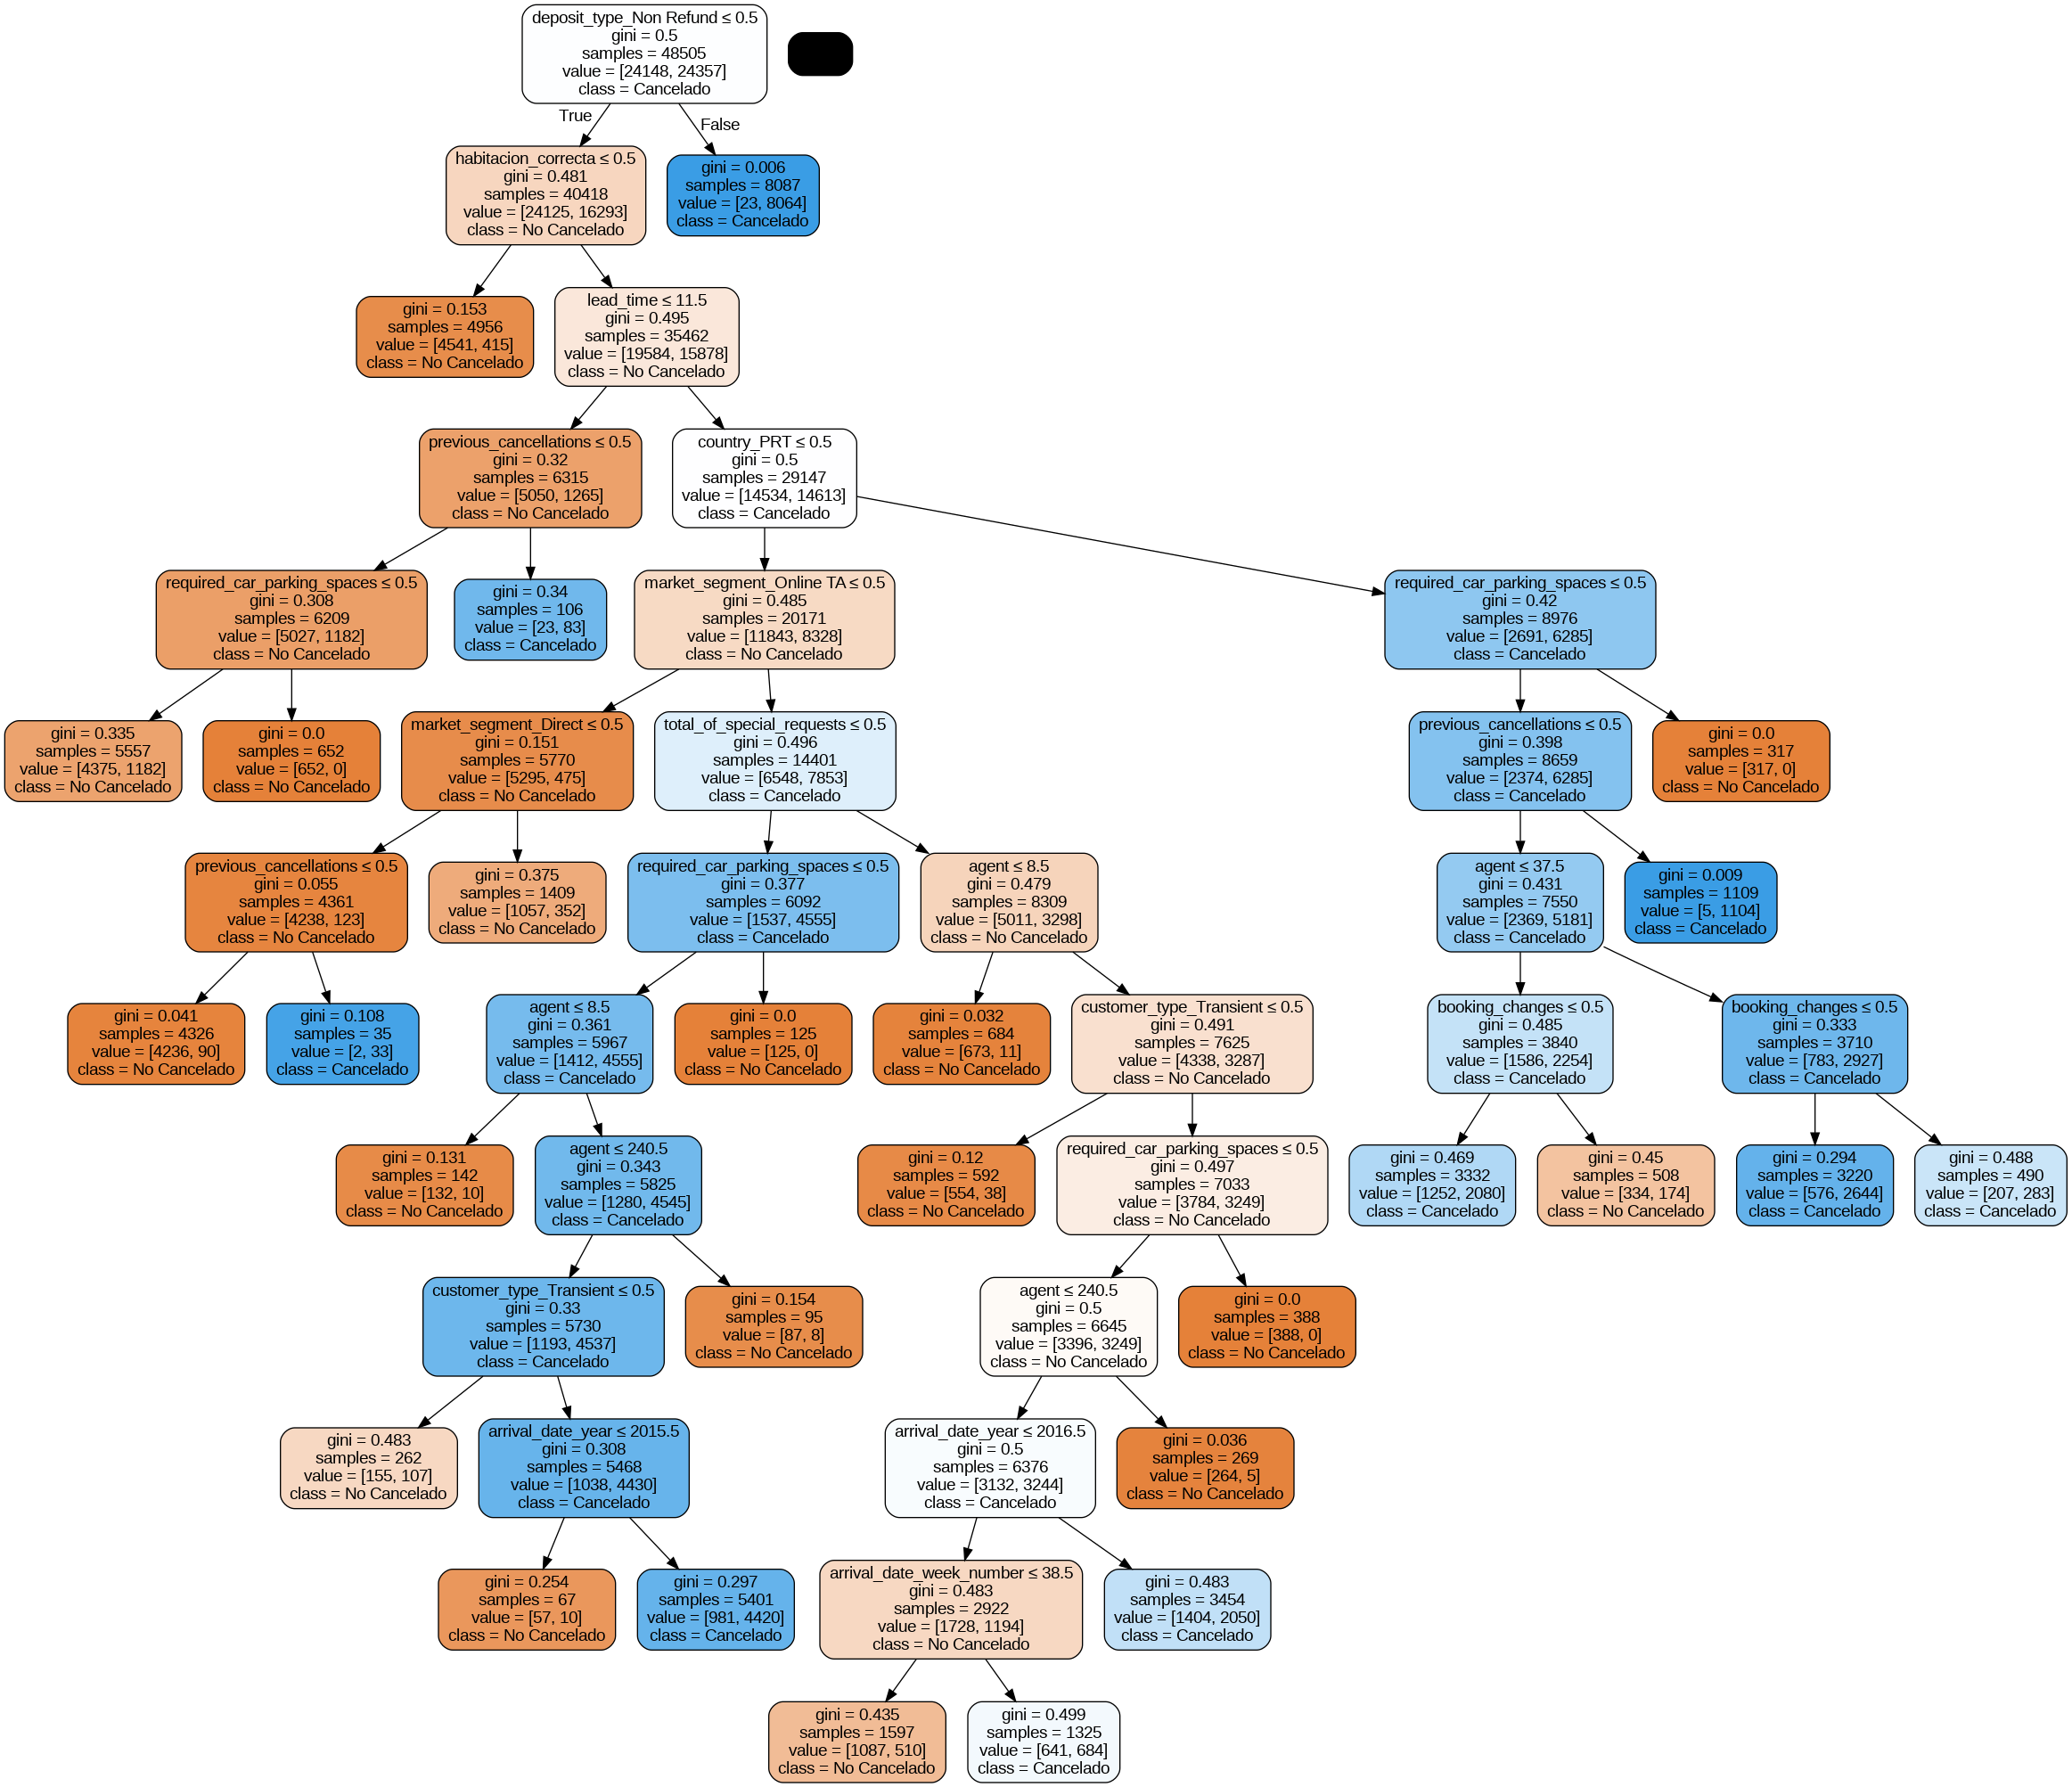

In [ ]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=df_trabajo_x.columns.to_list(),
                class_names=['No Cancelado','Cancelado'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      6037
           1       0.81      0.88      0.84      6090

    accuracy                           0.83     12127
   macro avg       0.84      0.83      0.83     12127
weighted avg       0.84      0.83      0.83     12127

F1-Score: 0.8411200251691049


Text(50.722222222222214, 0.5, 'True')

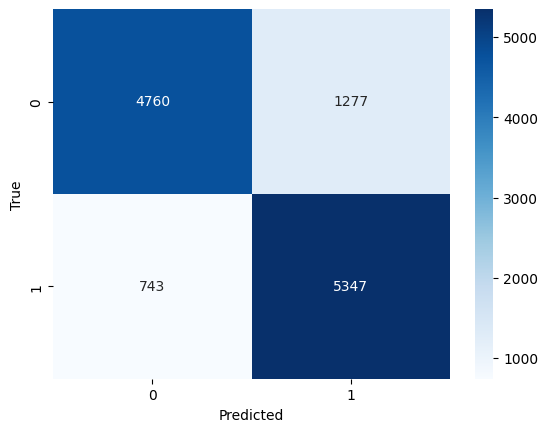

In [ ]:
#Evalúo el Arbol con los mejores hiperparámetros

#Hago predicción sobre el set de evaluacion
y_pred= arbol.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Arbol 6 - Grid search




In [ ]:
from sklearn.model_selection import GridSearchCV

#Cantidad de combinaciones que quiero porbar
n= 10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,12))}
                
#Cantidad de splits para el Cross Validation
folds= 10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.accuracy_score)

#GridSearch CV
gridcv = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

gridcv.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             return_train_score='True', scoring=make_scorer(accuracy_score))

In [ ]:
#Mejores hiperparametros del arbol
print(gridcv.best_params_)
#Mejor métrica
print(gridcv.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 11}
0.841933524175056


In [ ]:
y_pred = gridcv.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8412632967757896


## Arbol 7 - Grid search


In [ ]:
from sklearn.model_selection import GridSearchCV

#Cantidad de combinaciones que quiero porbar
n= 15

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.005,n), 
               'max_depth':list(range(1,14))}
                
#Cantidad de splits para el Cross Validation
folds= 10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.accuracy_score)

#GridSearch CV
gridcv2 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

gridcv2.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00035714, 0.00071429, 0.00107143, 0.00142857,
       0.00178571, 0.00214286, 0.0025    , 0.00285714, 0.00321429,
       0.00357143, 0.00392857, 0.00428571, 0.00464286, 0.005     ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13]},
             return_train_score='True', scoring=make_scorer(accuracy_score))

In [ ]:
#Mejores hiperparametros del arbol
print(gridcv2.best_params_)
#Mejor métrica
print(gridcv2.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 13}
0.8506955989518582


In [ ]:
y_pred = gridcv2.predict(x_test)
accuracy2 = accuracy_score(y_test, y_pred)
print(accuracy2)

0.8501690442813556


## Arbol 8 - Grid Search 

In [ ]:
from sklearn.model_selection import GridSearchCV

#Cantidad de combinaciones que quiero porbar
n= 15

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.01,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds= 10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.accuracy_score)

#GridSearch CV
gridcv3 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

gridcv3.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00071429, 0.00142857, 0.00214286, 0.00285714,
       0.00357143, 0.00428571, 0.005     , 0.00571429, 0.00642857,
       0.00714286, 0.00785714, 0.00857143, 0.00928571, 0.01      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             return_train_score='True', scoring=make_scorer(accuracy_score))

In [ ]:
#Mejores hiperparametros del arbol
print(gridcv3.best_params_)
#Mejor métrica
print(gridcv3.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 11}
0.8420159771499977


In [ ]:
y_pred = gridcv3.predict(x_test)
accuracy3 = accuracy_score(y_test, y_pred)
print(accuracy3)

0.8416755999010472


## Submission

In [ ]:
#AGent
pivot_table = pd.pivot_table(df_trabajo, index="agent", columns="is_canceled", values="id", aggfunc="count", fill_value=0) 
pivot_table.columns = ["No Cancelado", "Cancelado"]
pivot_table["Total"] = pivot_table["No Cancelado"] + pivot_table["Cancelado"]
pivot_table["Porcentaje de Cancelados"] = np.rint(pivot_table["Cancelado"]/pivot_table["Total"]*100)

agents = pivot_table[(pivot_table["Porcentaje de Cancelados"] > 65) & (pivot_table["Total"] > 100)].index.to_list()

df_test["agent_cancela_seguido"] = df_test["agent"].isin(agents)

#Habitacion correcta
df_test['habitacion_correcta'] = (df_test['reserved_room_type'] == df_test['assigned_room_type'])

#Estadia
stay_mapping = {
    0: "Reservas sin\nnoches",
    1: "Reservas entre\nsemana",
    2: "Reservas en fin\nde semana",
    3: "Reserva con\nambos casos"
}

df_test['estadia'] = (
    df_test['stays_in_weekend_nights'].apply(lambda x: 2 if x > 0 else 0) + 
    df_test['stays_in_week_nights'].apply(lambda x: 1 if x > 0 else 0)
)


df_test['estadia'] = df_test['estadia'].map(stay_mapping)

df_test['country'].fillna("Otros")

df_test.loc[df_test["assigned_room_type"].isin(["B", "C", "H","I","K","P","L"]), "assigned_room_type"] = "Otros"
df_test.loc[df_test["reserved_room_type"].isin(["B", "C", "H","I","K","P","L"]), "reserved_room_type"] = "Otros"

lista_paises = df_trabajo["country"].value_counts().index.to_list()
lista_paises.remove("Otros")

df_test.loc[~df_test["country"].isin(lista_paises), "country"] = "Otros"





In [ ]:
X_submission = pd.get_dummies(df_test, columns=['hotel','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type'], drop_first=True)

from sklearn.preprocessing import (
    LabelEncoder
)

le = LabelEncoder()
# Convertimos nulos a string 'nan', es decir un valor posible mas
for column in X_submission.columns:
    if X_submission[column].dtype == 'object':
        X_submission[column] = le.fit_transform(X_submission[column])

In [ ]:

#X_submission.drop(['id','company','arrival_date_month','arrival_date_week_number','arrival_date_year',"arrival_date_day_of_month",'children','babies','meal','reservation_status_date'], axis='columns',inplace=True)
X_submission.drop(['id','company','reservation_status_date'], axis='columns',inplace=True)
X_submission.fillna(0, inplace=True)

y_pred = randomcv5.predict(X_submission)
y_pred

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
df_submission = pd.DataFrame({'id': df_test['id'], 'is_canceled': y_pred})
df_submission.head()

id  is_canceled
0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1
1  aba9aac2-4495-4645-a60e-90328713c999            1
2  b345b5dc-c804-4d77-a39f-1f4e65d1f1ad            0
3  ce1b400e-afa1-4946-bdff-004b859eb61c            1
4  c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214            1

In [ ]:
df_submission.to_csv('/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Submission/inicial_submission15.csv', index=False)

## Guardado de modelos

In [ ]:
import joblib  

joblib.dump(cv1, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_1.joblib")
joblib.dump(cv2, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_2.joblib")
joblib.dump(randomcv1, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Random_1.joblib")
joblib.dump(randomcv2, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Random_2.joblib")
joblib.dump(randomcv3, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Random_3.joblib")
joblib.dump(randomcv4, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Random_4.joblib")
joblib.dump(randomcv5, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Random_5.joblib")
joblib.dump(randomcv1, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Random_1.joblib")
joblib.dump(randomcv1, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Random_1.joblib")
joblib.dump(gridcv, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Grid_1.joblib")
joblib.dump(gridcv2, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Grid_2.joblib")
joblib.dump(gridcv3, "/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Grid_3.joblib")

['/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Modelos/tree_model_Grid_3.joblib']

## Analisis para conseguir el mejor arbol

El mejor arbol que pudimos obtener fue haciendo Grid Search con 10 folds. Y para nosotros la mejor metrica para representar los arboles es f1_score ya que la misma toma en cuenta el "recall" y "accuracy", las demas metricas no son tan precisas o tan abarcativas de las demas metricas como lo es el f1_score.


Nos dimos cuenta que evaluando los diferentes modelos con folds entre 5 y 10 terminaban usando la misma cantidad de variables y practicamente las mismas en cada caso. Al usar mas folds no variaba tanto la diferencia.